# Copyright Netherlands eScience Center <br>
** Function     : Lead/Lag regression and energy budget - AMET (ERAI) & OMET (ORAS4) ** <br>
** Author       : Yang Liu ** <br>
** First Built  : 2018.08.15 ** <br>
** Last Update  : 2018.09.18 ** <br>
Description  : This script serves to investigate the compensation between energy transport in the atmosphere and ocean. It works with AMET and OMET estimated from ERA-Interim and ORAS4. Lead/lag regressions are performed to check the compensation.<br>
Return Values : jpeg <br>

In [1]:
%matplotlib inline

import sys
sys.path.append("/home/ESLT0068/NLeSC/Computation_Modeling/Bjerknes/Scripts/META")
import numpy as np
import scipy
from netCDF4 import Dataset
import matplotlib
import matplotlib.pyplot as plt
import os
import meta.statistics
import meta.visualizer

Initialization - Start with location of input and extraction of variables
Time span of each product:
- **ERA-Interim** 1979 - 2016
- **MERRA2**      1980 - 2016
- **JRA55**       1979 - 2015
- **ORAS4**       1958 - 2017
- **GLORYS2V3**   1993 - 2014
- **SODA3**       1980 - 2015

In [9]:
if __name__=="__main__":
    # sample
    ################################   Input zone  ######################################
    # specify data path
    datapath = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/warehouse_met'
    datapath_ERAI_AMET_SH = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/warehouse_met/SphericalHarmonics'
    output_path = '/home/ESLT0068/NLeSC/Computation_Modeling/Bjerknes/Compensation/MET_leadlag/stat_erai_oras_layer/leadlag/amet_SH_omet'
    #####################################################################################
    print ('*********************** extract variables *************************')
    dataset_ERAI_AMET = Dataset(os.path.join(datapath_ERAI_AMET_SH,
                                             'era_model_subdaily_1979_2017_amet_SH.nc'))
    dataset_ORAS4_OMET = Dataset(os.path.join(datapath,
                                              'oras_model_monthly_1958_2017_omet.nc'))
    dataset_ORAS4_OHC = Dataset(os.path.join(datapath,
                                              'oras_model_monthly_1958_2017_ohc.nc'))
    # extract time series from 1979 to 2016
    # from 20N - 90N
    # 3D fields [year, month, lat]
    # since OMET is from 20N - 90N, AMET is from 90N to 20N, we have to reverse it
    # for interpolation, x should be monotonically increasing
    AMET_0_ERAI = dataset_ERAI_AMET.variables['E_int'][:,:,:]/1000 # from Tera Watt to Peta Watt
    # 3D fields [year, month, lat]
    OMET_int_ORAS4 = dataset_ORAS4_OMET.variables['E_int'][21:,:,:]/1000 # from Tera Watt to Peta Watt # start from 1979
    OMET_atl_int_ORAS4 = dataset_ORAS4_OMET.variables['E_atl_int'][21:,:,:]/1000
    OMET_atl_100_int_ORAS4 = dataset_ORAS4_OMET.variables['E_atl_100_int'][21:,:,:]/1000
    OMET_atl_300_int_ORAS4 = dataset_ORAS4_OMET.variables['E_atl_300_int'][21:,:,:]/1000
    OMET_atl_700_int_ORAS4 = dataset_ORAS4_OMET.variables['E_atl_700_int'][21:,:,:]/1000
    OMET_atl_2000_int_ORAS4 = dataset_ORAS4_OMET.variables['E_atl_2000_int'][21:,:,:]/1000
    
    OMET_pac_int_ORAS4 = dataset_ORAS4_OMET.variables['E_pac_int'][21:,:,:]/1000
    # 3D fields [year, month, lat]
    OHC_int_ORAS4 = dataset_ORAS4_OHC.variables['OHC_int'][21:,:,:]/1000 # from Tera Watt to Peta Watt # start from 1979
    OHC_atl_int_ORAS4 = dataset_ORAS4_OHC.variables['OHC_atl_int'][21:,:,:]/1000
    OHC_atl_100_int_ORAS4 = dataset_ORAS4_OHC.variables['OHC_atl_100_int'][21:,:,:]/1000
    OHC_atl_300_int_ORAS4 = dataset_ORAS4_OHC.variables['OHC_atl_300_int'][21:,:,:]/1000
    OHC_atl_700_int_ORAS4 = dataset_ORAS4_OHC.variables['OHC_atl_700_int'][21:,:,:]/1000
    OHC_atl_2000_int_ORAS4 = dataset_ORAS4_OHC.variables['OHC_atl_2000_int'][21:,:,:]/1000   
    # other dimensions
    year_ORAS4 = dataset_ORAS4_OMET.variables['year'][21:-1]    # from 1979 to 2016
    year_ERAI = dataset_ERAI_AMET.variables['year']
    latitude_OMET_ORAS4 = dataset_ORAS4_OMET.variables['latitude_aux'][:]
    latitude_AMET_ERAI = dataset_ERAI_AMET.variables['latitude'][:]

*********************** extract variables *************************


In [22]:
    # check the latitude
    print (latitude_AMET_ERAI[156:228])

[19.99996  20.701714 21.403465 22.105219 22.806973 23.508724 24.210478
 24.91223  25.613983 26.315735 27.017488 27.71924  28.420994 29.122746
 29.8245   30.52625  31.228004 31.929756 32.631508 33.333263 34.035015
 34.736767 35.43852  36.14027  36.842022 37.543777 38.24553  38.94728
 39.649033 40.350784 41.052536 41.754288 42.45604  43.15779  43.859543
 44.561295 45.263046 45.964798 46.66655  47.3683   48.070053 48.771805
 49.473557 50.17531  50.87706  51.57881  52.28056  52.98231  53.684063
 54.385815 55.087563 55.789314 56.491062 57.192814 57.89456  58.596313
 59.29806  59.999813 60.70156  61.40331  62.105057 62.806805 63.508553
 64.210304 64.91205  65.61379  66.315544 67.01729  67.71903  68.42078
 69.12252  69.824265]


Perform interpolation as AMET and OMET has different resoltion in terms of the latitudes.

In [10]:
    print ('*******************  interpolation for regression   **********************')
    # interpolate OMET on the latitude of AMET
    # ORAS4 - ERAI
    # glole
    OMET_ORAS4_interp_ERAI = meta.statistics.operator.interpolation(OMET_int_ORAS4, 
                                 latitude_OMET_ORAS4, latitude_AMET_ERAI)
    # atlantic
    OMET_atl_ORAS4_interp_ERAI = meta.statistics.operator.interpolation(OMET_atl_int_ORAS4, 
                                 latitude_OMET_ORAS4, latitude_AMET_ERAI)
    # an easy check for the interpolation
    #plt.plot(latitude_AMET_ERAI,OMET_atl_ORAS4_interp_ERAI[2,11,:],linewidth=6.0)
    #plt.plot(latitude_OMET_ORAS4,OMET_atl_int_ORAS4[2,11,:])
    OMET_atl_100_ORAS4_interp_ERAI = meta.statistics.operator.interpolation(OMET_atl_100_int_ORAS4, 
                                 latitude_OMET_ORAS4, latitude_AMET_ERAI)
    OMET_atl_300_ORAS4_interp_ERAI = meta.statistics.operator.interpolation(OMET_atl_300_int_ORAS4, 
                                 latitude_OMET_ORAS4, latitude_AMET_ERAI)
    OMET_atl_700_ORAS4_interp_ERAI = meta.statistics.operator.interpolation(OMET_atl_700_int_ORAS4, 
                                 latitude_OMET_ORAS4, latitude_AMET_ERAI)
    OMET_atl_2000_ORAS4_interp_ERAI = meta.statistics.operator.interpolation(OMET_atl_2000_int_ORAS4, 
                                 latitude_OMET_ORAS4, latitude_AMET_ERAI)
    #pacific
    OMET_pac_ORAS4_interp_ERAI = meta.statistics.operator.interpolation(OMET_pac_int_ORAS4, 
                                 latitude_OMET_ORAS4, latitude_AMET_ERAI)
    
    # interpolate OHC on the latitude of AMET
    # atlantic
    OHC_atl_ORAS4_interp_ERAI = meta.statistics.operator.interpolation(OHC_atl_int_ORAS4, 
                                latitude_OMET_ORAS4, latitude_AMET_ERAI)
    # an easy check for the interpolation
    #plt.plot(latitude_AMET_ERAI,OHC_atl_ORAS4_interp_ERAI[2,11,:],linewidth=6.0)
    #plt.plot(latitude_OMET_ORAS4,OHC_atl_int_ORAS4[2,11,:])
    OHC_atl_100_ORAS4_interp_ERAI = meta.statistics.operator.interpolation(OHC_atl_100_int_ORAS4, 
                                    latitude_OMET_ORAS4, latitude_AMET_ERAI)
    OHC_atl_300_ORAS4_interp_ERAI = meta.statistics.operator.interpolation(OHC_atl_300_int_ORAS4, 
                                    latitude_OMET_ORAS4, latitude_AMET_ERAI)
    OHC_atl_700_ORAS4_interp_ERAI = meta.statistics.operator.interpolation(OHC_atl_700_int_ORAS4, 
                                    latitude_OMET_ORAS4, latitude_AMET_ERAI)
    OHC_atl_2000_ORAS4_interp_ERAI = meta.statistics.operator.interpolation(OHC_atl_2000_int_ORAS4, 
                                     latitude_OMET_ORAS4, latitude_AMET_ERAI)

*******************  interpolation for regression   **********************


*******************  postprocess with statistical tool  *********************
***********!@#$%^&*  Lead/ Lag regression of ORAS4 - ERAI  !@#$%^&***********
======================   AMET + 0 & OMET + atl + 0   ========================
The input data has the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data has the dimension of month.
The output anomaly time series only contains one dimension for time!
One time series with 2 dimensions is regressed on another.
One time series with 2 dimensions is regressed on another.
This a regression with lead/lag analysis.
One time series with 2 dimensions is regressed on another.
This a regression with lead/lag analysis.
Create contour plot of correlation coefficient.


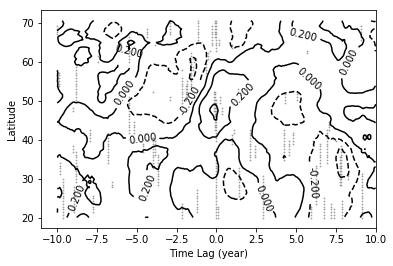

In [43]:
    print ('*******************  postprocess with statistical tool  *********************')
    print ('***********!@#$%^&*  Lead/ Lag regression of ORAS4 - ERAI  !@#$%^&***********')
    print ('======================   AMET + 0 & OMET + atl + 0   ========================')
    stat_AMET_ERAI = meta.statistics.operator(AMET_0_ERAI)
    stat_AMET_ERAI.anomaly()
    stat_AMET_ERAI.detrend()
    # by default, the running mean is taken with a window of 60 months
    stat_AMET_ERAI.lowpass(window=60, obj='detrend')
    stat_OMET_ORAS4 = meta.statistics.operator(OMET_atl_ORAS4_interp_ERAI)
    stat_OMET_ORAS4.anomaly()
    stat_OMET_ORAS4.detrend()
    stat_OMET_ORAS4.lowpass(window=60, obj='detrend')
    k, r, p = meta.statistics.operator.linearRegress(stat_AMET_ERAI._lowpass,
                                                     stat_OMET_ORAS4._lowpass)
    #meta.visualizer.plots.linearRegress(latitude_AMET_ERAI, r,
    #                                    os.path.join(output_path,'regress_ERAI_0_ORAS4_atl_0.png'))
    # set the lead lag
    lag = 120
    k, r, p = meta.statistics.operator.linearRegress(stat_AMET_ERAI._lowpass,
                                                     stat_OMET_ORAS4._lowpass, lag)
    _, _, p_real = meta.statistics.operator.linearRegress(stat_AMET_ERAI._detrend,
                                                          stat_OMET_ORAS4._detrend, lag)
    # r[lag,lat]
    meta.visualizer.plots.leadlagRegress(latitude_AMET_ERAI[156:229], r[:,156:229], lag, p_real[:,156:229],
                                         os.path.join(output_path,
                                         'leadlag_ERAI_0_ORAS4_atl_0_omet_decadal.png'), ttest=True)

======================   AMET + 0 & OMET + pac + 0   ========================
The input data has the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data has the dimension of month.
The output anomaly time series only contains one dimension for time!
One time series with 2 dimensions is regressed on another.
One time series with 2 dimensions is regressed on another.
This a regression with lead/lag analysis.
Create contour plot of correlation coefficient.


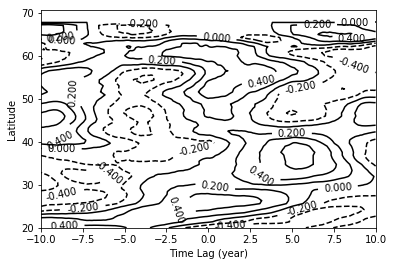

In [27]:
    print ('======================   AMET + 0 & OMET + pac + 0   ========================')
    stat_AMET_ERAI = meta.statistics.operator(AMET_0_ERAI)
    stat_AMET_ERAI.anomaly()
    stat_AMET_ERAI.detrend()
    # by default, the running mean is taken with a window of 60 months
    stat_AMET_ERAI.lowpass(window=60, obj='detrend')
    stat_OMET_ORAS4 = meta.statistics.operator(OMET_pac_ORAS4_interp_ERAI)
    stat_OMET_ORAS4.anomaly()
    stat_OMET_ORAS4.detrend()
    stat_OMET_ORAS4.lowpass(window=60, obj='detrend')
    k, r, p = meta.statistics.operator.linearRegress(stat_AMET_ERAI._lowpass,
                                                     stat_OMET_ORAS4._lowpass)
    #meta.visualizer.plots.linearRegress(latitude_AMET_ERAI, r,
    #                                    os.path.join(output_path,'regress_ERAI_0_ORAS4_atl_0.png'))
    # set the lead lag
    lag = 120
    k, r, p = meta.statistics.operator.linearRegress(stat_AMET_ERAI._lowpass,
                                                     stat_OMET_ORAS4._lowpass, lag)
    # r[lag,lat]
    meta.visualizer.plots.leadlagRegress(latitude_AMET_ERAI[156:229], r[:,156:229], lag, p,
                                         os.path.join(output_path,
                                         'leadlag_ERAI_0_ORAS4_pac_0_omet_interannual.png'))

======================   AMET + 0 & OMET + glo + 0   ========================
The input data has the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data has the dimension of month.
The output anomaly time series only contains one dimension for time!
One time series with 2 dimensions is regressed on another.
One time series with 2 dimensions is regressed on another.
This a regression with lead/lag analysis.
One time series with 2 dimensions is regressed on another.
This a regression with lead/lag analysis.
Create contour plot of correlation coefficient.


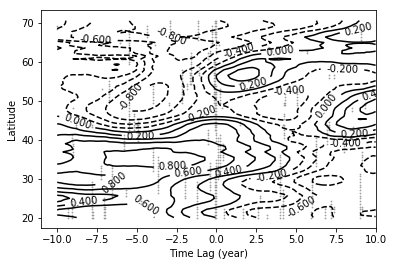

In [37]:
    print ('======================   AMET + 0 & OMET + glo + 0   ========================')
    stat_AMET_ERAI = meta.statistics.operator(AMET_0_ERAI)
    stat_AMET_ERAI.anomaly()
    stat_AMET_ERAI.detrend()
    # by default, the running mean is taken with a window of 60 months
    stat_AMET_ERAI.lowpass(window=180, obj='detrend')
    stat_OMET_ORAS4 = meta.statistics.operator(OMET_ORAS4_interp_ERAI)
    stat_OMET_ORAS4.anomaly()
    stat_OMET_ORAS4.detrend()
    stat_OMET_ORAS4.lowpass(window=180, obj='detrend')
    k, r, p = meta.statistics.operator.linearRegress(stat_AMET_ERAI._lowpass,
                                                     stat_OMET_ORAS4._lowpass)
    #meta.visualizer.plots.linearRegress(latitude_AMET_ERAI, r,
    #                                    os.path.join(output_path,'regress_ERAI_0_ORAS4_atl_0.png'))
    # set the lead lag
    lag = 120
    k, r, p = meta.statistics.operator.linearRegress(stat_AMET_ERAI._lowpass,
                                                     stat_OMET_ORAS4._lowpass, lag)
    _, _, p_real = meta.statistics.operator.linearRegress(stat_AMET_ERAI._detrend,
                                                          stat_OMET_ORAS4._detrend, lag)
    # r[lag,lat]
    meta.visualizer.plots.leadlagRegress(latitude_AMET_ERAI[156:229], r[:,156:229], lag, p_real[:,156:229],
                                         os.path.join(output_path,
                                         'leadlag_ERAI_0_ORAS4_globe_0_omet_interdecadal.png'), ttest=True)